In [11]:
#Conda imports
import numpy as np
from scipy.linalg import qr
import time
import random
import matplotlib.pyplot as plt
import itertools
from numpy.polynomial.chebyshev import chebroots, chebval
#from numalgsolve.TelenVanBarel import sorted_matrix_terms
from numalgsolve.utils import inverse_P, row_swap_matrix
from numalgsolve.utils import mon_combosHighest, slice_top, mon_combos, newton_polish
from numalgsolve._stability import maximal_residual
from scipy.misc import comb
#Local imports
from numalgsolve.polynomial import MultiCheb, MultiPower, getPoly
from scipy.linalg import eig
from numalgsolve.Division import division
from numalgsolve.Multiplication import multiplication
from numalgsolve.subdivision import good_zeros_nd, subdivision_solve_nd, solve
from  matplotlib import patches as patches

%matplotlib inline

# Auto-reload packages
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

def polyList(deg,dim,power,Type = 'standard',triangular = True):
    deg += 1
    coeffs = list()
    if Type == 'random':
        for i in range(dim):
            coeffs.append(np.random.random_sample(deg*np.ones(dim, dtype = int)))
    elif Type == 'int':
        Range = 1000
        for i in range(dim):
            coeffs.append(np.random.randint(-Range,Range,deg*np.ones(dim, dtype = int)))
    elif Type == 'standard':
        for i in range(dim):
            coeffs.append(np.random.standard_normal(deg*np.ones(dim, dtype = int)))
    if triangular:
        for i,j in np.ndenumerate(coeffs[0]):
            if np.sum(i) >= deg:
                for coeff in coeffs:
                    coeff[i] = 0
    polys = list()
    if power:
        for coeff in coeffs:
            polys.append(MultiPower(coeff))
    else:
        for coeff in coeffs:
            polys.append(MultiCheb(coeff))
    return polys

def evaluate(zero, polys, accuracy = 1.e-3):
    good = True
    outOfRange = False
    for poly in polys:
        if not np.isclose(0, poly.evaluate_at(zero), atol = accuracy):
            good = False
            if (np.abs(zero) > 1).any():
                outOfRange = True
            break
    return good,outOfRange

def checkZeros(zeros, polys, accuracy = 1.e-3):
    if zeros == -1:
        print(-1)
        return
    results = np.apply_along_axis(evaluate, 1, zeros, polys, accuracy = accuracy)
    correct = np.sum(results[:,0])
    outOfRange = np.sum(results[:,1])
    print("{} ZEROS ARE CORRECT OUT OF {}".format(correct, len(zeros)))
    print("{} of them were about of range".format(outOfRange))
    print("{} percent of zeros in range correct".format(np.round(100*correct/(len(zeros)-outOfRange),3)))

def coeffToString(matrix):
    result = ''
    for mon in zip(*np.where(matrix != 0)):
        coeff = matrix[mon]
        mon = mon[::-1]
        if coeff >= 0:
            monString = '+' + str(coeff) + '*'
        else:
            monString = str(coeff) + '*'
        for i in range(len(mon)):
            if mon[i] == 0:
                continue
            monString += 'x'
            monString += str(i)
            if mon[i] > 1:
                monString += '^'
                monString += str(mon[i])
            monString+= '*'
        #if monString[-1] == '*':
        monString = monString[:-1]
        result += monString
    if result[0] == '+':
        result = result[1:]
    return result

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [12]:
from numalgsolve.polynomial import cheb2poly
from subprocess import run
input_file_path = '../../BertiniApple32_v1.5.1/input'
output_file_path = 'finite_solutions'
bertini_run_process = ['../../BertiniApple32_v1.5.1/bertini', '../../BertiniApple32_v1.5.1/input']
def prep_bertini(polys):
    if isinstance(polys[0], MultiCheb):
        polysNew = []
        for poly in polys:
            polysNew.append(cheb2poly(poly))
        polys = polysNew
    num_polys = len(polys)
    function_string = 'function '
    for i in range(num_polys):
        function_string += 'f' + str(i) + ', '
    function_string = function_string[:-2] + ';' + '\n'
    dim = polys[0].dim
    variable_string = 'variable_group '
    for i in range(dim):
        variable_string += 'x' + str(i) + ', '
    variable_string = variable_string[:-2] + ';' + '\n'
    with open(input_file_path, 'w') as input_file:
        input_file.write(function_string)
        input_file.write(variable_string)
        for i in range(num_polys):
            input_file.write('f' + str(i) + ' = ' + coeffToString(polys[i].coeff) + ';\n')
        input_file.write('END;')

def bertini_results(dim):
    with open(output_file_path, 'r') as output_file:
        results = output_file.readlines()
    def get_number(line):
        nums = line.split(' ')
        return complex(float(nums[0]), float(nums[1]))

    #print(results)
    zeros = list()
    for i in range(2,len(results),dim+1):
        zero = np.zeros(dim, dtype = 'complex')
        for j in range(dim):
            zero[j] = get_number(results[i+dim-1-j])
        zeros.append(zero)
        #zeros.append(np.array([get_number(results[i+1]), get_number(results[i])]))
    return np.vstack(zeros)

def run_bertini(polys):
    prep_bertini(polys)
    run(bertini_run_process)
    return bertini_results(polys[0].dim)

def in_zeros(zeros, zero_to_check, tol = 1.e-5):
    for zero in zeros:
        if np.allclose(zero - zero_to_check,np.zeros_like(zero), atol=tol):
            return True
    return False

def run_trial(polys, method, tol = 1.e-5):
    if method.__name__ == 'solve':
        a = np.array([-1.]*len(polys))
        b = np.array([1.]*len(polys))
        zeros = method(polys, a, b)
    else:
        zeros = method(polys)
    if not power:
        for i in range(len(polys)):
            polys[i] = cheb2poly(polys[i])
    zeros_bertini = run_bertini(polys)
    trial_results(zeros, zeros_bertini, tol = tol)

def trial_results(zerosUS, zeros_bertini, tol = 1.e-5):
    zeros_bertini = zeros_bertini[np.sum(np.abs(np.imag(zeros_bertini)) < 1.e-10, axis = 1) == zeros_bertini.shape[1]]
    zeros_bertini = zeros_bertini[np.sum(np.abs(zeros_bertini) <= 1, axis = 1) == dim]
    zerosUS = zerosUS[np.sum(np.abs(np.imag(zerosUS)) < 1.e-10, axis = 1) == zerosUS.shape[1]]
    zerosUS = zerosUS[np.sum(np.abs(zerosUS) <= 1, axis = 1) == dim]
    
    print('We were - {} out of {}'.format(np.sum([in_zeros(zerosUS, zero_bertini, tol=tol)\
                                              for zero_bertini in zeros_bertini]),len(zeros_bertini)))
#     min_mag = 1000
#     for zero_bertini in zeros_bertini:
#         if not in_zeros(zerosUS, zero_bertini, tol=tol):
#             min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
#             #assert(np.any(np.abs(zero_bertini) > 1))
#     print(min_mag)

In [13]:
from scipy.io import wavfile
import IPython
import scipy as sp
import time
from scipy import signal, fft, exp
from scipy.misc import imread
class SoundWave(object):
    """A SoundWave class for working with digital audio signals.
    Attributes:
        rate (int): The sample rate of the sound.
        samples ((n,) ndarray): NumPy array of samples.
    """
    # Problem 1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.
        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        Returns:
            A SoundWave object.
        """
        self.samples = samples
        self.rate = rate
    
    def plot(self):
        """Plot and display the graph of the sound wave."""
        xs = np.arange(len(self.samples))/self.rate
        plt.plot(xs,self.samples)
        plt.show()
        
    # Problem 2
    def export(self, filename):
        """Generate a wav file called filename from the sample rate and samples. 
        If the array of samples is not of type int16, scale it so that it is."""
        wavfile.write(filename, self.rate, np.int16(self.samples.real*(32767/np.max(np.abs(self.samples.real)))))
    
    # Problem 4
    def __add__(self, other):
        """Add two sound waves together into one wave."""
        if len(self.samples) != len(other.samples):
            raise ValueError('Sample length must be the same!')
        return SoundWave(self.rate, self.samples + other.samples)
    
    def append(self, other):
        """Append additional samples to the end of the current samples."""
        if self.rate != other.rate:
            raise ValueError('Sample rates must be the same!')
        self.samples = np.hstack((self.samples, other.samples))
        
    # Problem 7
    def plot_dft(self):
        """Take the DFT of the sound wave. Scale the x-axis so the x-values correspond
        to the frequencies present in the plot. Display the left half of the plot."""
        dft = abs(fft(self.samples).real)       # Ignore the complex part.
        N = dft.shape[0]
        x_vals = np.linspace(1, N, N)
        x_vals = x_vals * 44100 / N
        end = int(len(x_vals)/2)
        plt.plot(x_vals[:end], dft[:end])
def generate_note(frequency, duration):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 samples per second.
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    duration/=1.6
    frequency*=1
    samplerate = 44100
    wave_function = lambda x: np.sin(2*np.pi*x*frequency)
    sample_points = np.linspace(0, duration, int(samplerate*duration))
    samples = wave_function(sample_points)
    sound = SoundWave(samplerate, samples)
    return sound
def make_song(notes):
    frequency_dict = {}
    frequency_dict['G0'] = 195.9975
    frequency_dict['A'] = 440
    frequency_dict['B'] = 493.88
    frequency_dict['C'] = 523.25
    frequency_dict['C#'] =277.18*2
    frequency_dict['D'] = 587.33
    frequency_dict['E'] = 659.25
    frequency_dict['F'] = 369.994*2#698.46
    frequency_dict['G'] = 783.99
    frequency_dict['A1'] = 440*2
    frequency_dict['B1'] = 493.88*2
    frequency_dict['C1'] = 523.25*2
    frequency_dict['D1'] = 587.33*2
    frequency_dict['E1'] = 659.25*2
    frequency_dict['F1'] = 369.994*4#698.46*2
    frequency_dict['G1'] = 783.99*2

    wave = np.sum([generate_note(frequency_dict[note],notes[0][-2]) for note in notes[0][:-2]])
    wave.append(generate_note(0,notes[0][-1]))
    for chord in notes[1:]:
        wave.append(np.sum([generate_note(frequency_dict[note],chord[-2]) for note in chord[:-2]]))
        wave.append(generate_note(0,chord[-1]))
    return wave

notes = [['G','D',.4,.1],['G','D',.9,.1],['D',.5,0],['G','B',.4,.1],['A1','D',1,0],['D',1,0],
         ['B1','D',.5,0],['A1','D',.48,.02],['B1','D',.5,0],['C1','E',.48,.02],['B1','D',1,0],['A1','D',.4,.1],
         ['B','G',.4,.1],['G','B',.5,0],['G','C#',.5,0],['D','F',.4,.1],
         ['C#','E',.4,.1],['D','F',.5,0],['D','G',.45,.05],['D','A1',.45,.05],['D','B1',.45,.05],
         ['D','F',1,0],['C#','E',.7,.05],['D',.2,.05],['D',1.5,.5],
         ['D','D1',.8,.2],['E','C1',.25,0],['F','C1',.25,0],['G','B1',.45,.05],
         ['E','C1',.5,0],['F','C1',.5,0],['G','B1',.8,.2],['D','A1',.5,0],['D','B1',.45,.05],
         ['E','G',.5,0],['E','A1',.45,.05],['D','F',.75,0],['E',.22,.03],['D',.4,.1],
         ['G',.45,.05],['G',.45,.05],['F',.45,.05],['G',.45,.05],['A1',.45,.05],['G',.9,.1],['D',.4,.1],
         ['D','B1',.45,.05],['D','B1',.45,.05],['D','A1',.45,.05],['D','B1',.45,.05],['F','C1',.45,.05],
         ['G','B1',.9,.1],['F','A1',.4,.1],['G','B1',.45,.05],
         ['E','C1',.25,.0],['F','C1',.2,.05],['G','B1',.45,.05],['C','A1',.45,.05],
         ['D','G',.25,.0],['G','C#',.2,.05],['F','D',.8,.2],['D','G',.5,0],['E','C1',.4,.1],
         ['D','B1',1,0],['C','A1',.7,.05],['B','G',.2,.05],['B','G',1.2,.05]
        ]
song = make_song(notes)
def play_song():
    return IPython.display.Audio(rate=song.rate, data=song.samples, autoplay=True)

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
deg = 25
dim = 2
power = False
polys2 = polyList(deg,dim,power,triangular=True)

In [ ]:
%time zerosDiv = division(polys2)
real_zeros = zerosDiv[np.sum(np.imag(zerosDiv) == 0, axis = 1) == dim]
real_zeros = real_zeros[np.sum(np.abs(real_zeros) <= 1, axis = 1) == dim]

In [ ]:
x = 0.588780061566-0.572463729298j
y = -1.01604993169-0.667426447156j
c = 0.000694845353877+0.00111022343908j
c*T(1,x)*T(7,y), c*T(8,x)*T(1,y), c*T(6,x)*T(3,y), c*T(1,x)*T(1,y), c*T(1,x)*T(0,y)

In [ ]:
#run_trial(polys, division, tol=1.e-3)
def T(n,point):
    c = np.zeros(n+1)
    c[-1] = 1
    return chebval(point,c)

In [419]:
def f(x,y):
    i = 0
    result = y**2*(4*y**2-i/10)-x**2*(4*x**2-1)
    for i in range(1,11):
        result *= (y**2*(4*y**2-i/10)-x**2*(4*x**2-1))
    return result

def g(x,y):
    return 256*(x**2+y**2)**2+288*(x**2+y**2)-512*(x**3-3*x*y**2)-27

Probably bad count 0, actually bad counts 0, errors 0
Total intervals checked was 637
Methods used were ['constant_term_check', 'full_quad_check', 'full_cubic_check', 'Division', 'Base Case']
The percent solved by each was [67.03  0.63  0.    0.   32.34]


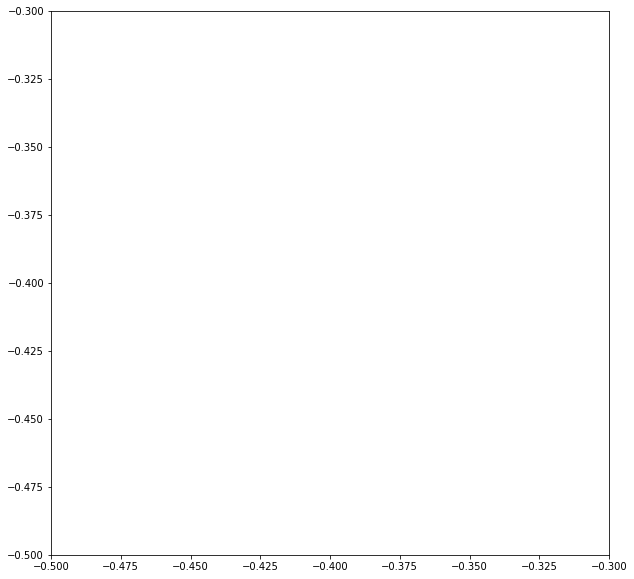

CPU times: user 3.11 s, sys: 42.9 ms, total: 3.15 s
Wall time: 3.19 s


In [428]:
a = np.array([-.5]*dim)
b = np.array([-.3]*dim)
%time zeros2 = solve([f,g], a, b, interval_data=True, plot_intervals=False,\
                     contours=True, show_zeros=True, polish = False)

Probably bad count 0, actually bad counts 0, errors 3
Total intervals checked was 10
Methods used were ['constant_term_check', 'full_quad_check', 'full_cubic_check', 'Division', 'Base Case']
The percent solved by each was [60.  0.  0. 40.  0.]


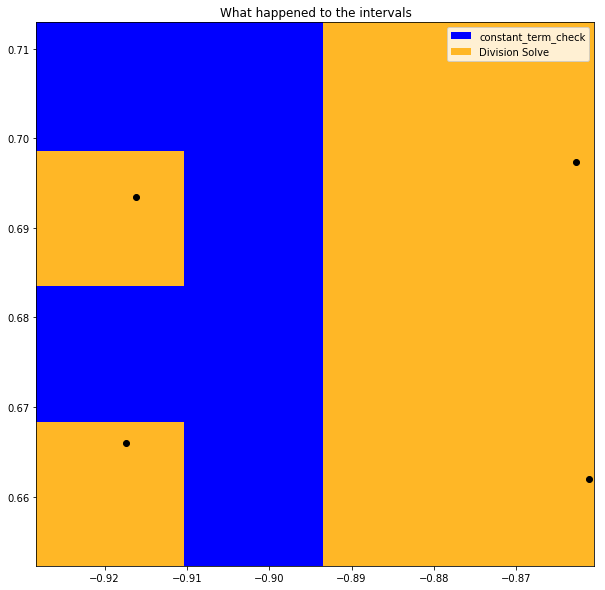

In [430]:
f = lambda x,y: np.sin(30*x-y/30)+y
g = lambda x,y: np.sin(x/30-30*y)-x
a = np.array([-0.92829466, 0.65227869])
b = np.array([-0.86047655, 0.7129431])
zeros2 = solve([f,g], a, b, interval_data=True, plot_intervals=True,\
                     contours=True, show_zeros=True, polish = False)

In [378]:
new_zeros = zeros2[zeros2[:,0] > .6]

In [379]:
new_zeros = new_zeros[new_zeros[:,1] > -.8]

In [380]:
new_zeros

array([], shape=(0, 2), dtype=complex128)

In [381]:
steps = [1,0,3,0,3]
a,b = get_interval(steps)
get_interval(steps)

(array([ 0.65227869, -0.02951494]), array([0.7129431 , 0.02786078]))

Probably bad count 0, actually bad counts 0, errors 0
Total intervals checked was 1
Methods used were ['constant_term_check', 'full_quad_check', 'full_cubic_check', 'Division', 'Base Case']
The percent solved by each was [  0.   0.   0. 100.   0.]


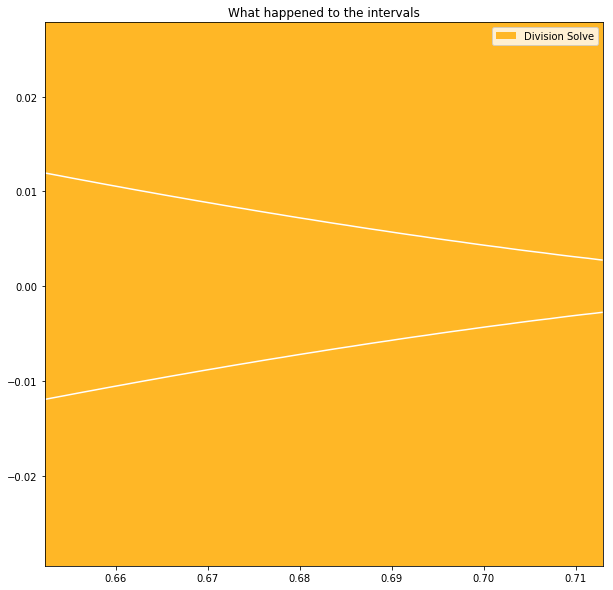

CPU times: user 2.68 s, sys: 26.1 ms, total: 2.7 s
Wall time: 2.75 s


In [382]:
%time zeros2 = solve([f,g], a, b, interval_data=True, plot_intervals=True,\
                     contours=True, show_zeros=True, polish = False)

In [245]:
g(zeros2)

array([-0.13094392+0.j, -0.10339475+0.j, -0.17802269+0.j])

In [415]:
def f(x,y):
    return 50*np.cos(50*x)*np.exp(np.sin(50*x)) + np.cos(70*np.sin(x))*70*np.cos(x) - \
            10*np.cos(10*(x + y)) + x/2
    
def g(x,y):
    return 60*np.exp(y)*np.cos(60*np.exp(y)) + np.cos(np.sin(80*y))*80*np.cos(80*y) - \
            10*np.cos(10*(x + y)) + y/2

In [416]:
a = np.array([-1.,-1.])
b = np.array([1.,1.])
%time zeros2 = solve([f,g], a, b, interval_data=True, plot_intervals=False,\
                     contours=True, show_zeros=True, polish = False)

TypeError: f() takes 1 positional argument but 2 were given

In [391]:
zeros2.shape

(2722, 2)

In [395]:
np.max(np.abs(f(zeros2))), np.max(np.abs(g(zeros2)))

(0.00745262722954082, 0.008868320630860183)

In [401]:
len(np.unique(zeros2.round(4) , axis=0))

2719

In [385]:
def big_func(x,y):
    return np.exp(np.sin(50*x)) + np.sin(60*np.exp(y)) + np.sin(70*np.sin(x)) + np.sin(np.sin(80*y)) - \
            np.sin(10*(x+y)) + (x**2 + y**2)/4

In [386]:
vals = big_func(zeros2[:,0],zeros2[:,1])
minimizer = np.argmin(vals)
vals[minimizer], zeros2[minimizer]

((-0.8752266625423847+0j), array([-0.17893891+0.j,  0.4334087 +0.j]))

In [364]:
from scipy.optimize import root as scipy_root

In [402]:
def full_func(x):
    return np.array([f(x),g(x)])
def f(x):
    return 50*np.cos(50*x[0])*np.exp(np.sin(50*x[0])) + np.cos(70*np.sin(x[0]))*70*np.cos(x[0]) - \
            10*np.cos(10*(x[0] + x[1])) + x[0]/2
    
def g(x):
    return 60*np.exp(x[1])*np.cos(60*np.exp(x[1])) + np.cos(np.sin(80*x[1]))*80*np.cos(80*x[1]) - \
            10*np.cos(10*(x[0] + x[1])) + x[1]/2
polished_zeros = []
for zero in zeros2:
    polished_zeros.append(scipy_root(full_func, np.real(zero)).x)
polished_zeros = np.vstack(polished_zeros)

In [366]:
vals = big_func(polished_zeros[:,0],polished_zeros[:,1])
minimizer = np.argmin(vals)
vals[minimizer], polished_zeros[minimizer]

(-3.3068686474752376, array([-0.02440308,  0.21061243]))

In [357]:
real_min = np.array([-.0244030796943751719036133083297, .210612427155355770591591100555])
big_func(real_min[0], real_min[1])

-3.3068686474752367

In [358]:
full_func(real_min)

array([-1.83707216e-15,  1.67865721e-13])

In [412]:
len(polished_zeros)

2722

In [406]:
np.max(np.abs(f(polished_zeros))), np.max(np.abs(g(polished_zeros)))

(8.130927597882476e-10, 2.635647255999629e-11)

In [409]:
len(np.unique(polished_zeros.round(10) , axis=0))

2719

In [53]:
deg = 15
dim = 2
power = False
polys = polyList(deg,dim,power,triangular=True)

In [121]:
%time zerosDiv = division(polys)
real_zeros = zerosDiv[np.sum(np.imag(zerosDiv) == 0, axis = 1) == dim]
real_zeros = real_zeros[np.sum(np.abs(real_zeros) <= 1, axis = 1) == dim]

CPU times: user 675 ms, sys: 27.7 ms, total: 702 ms
Wall time: 462 ms


Interval -  [0.80149611 0.52747267] [0.83098324 0.56043699]
Interval -  [0.52747267 0.94573468] [0.56043699 0.97362328]
Interval -  [0.52747267 0.91784609] [0.54441403 0.93217888]
Interval -  [0.40943253 0.34876812] [0.47009695 0.40943253]
Interval -  [-1.         0.6986103] [-0.98106087  0.7129431 ]
Probably bad count 0, actually bad counts 0, errors 245
Total intervals checked was 2245
Methods used were ['constant_term_check', 'full_quad_check', 'full_cubic_check', 'Division', 'Base Case']
The percent solved by each was [88.33  3.88  0.31  7.48  0.  ]


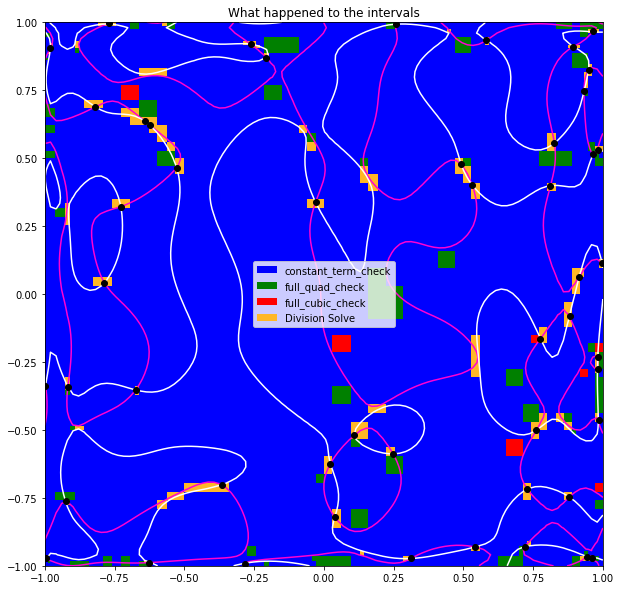

CPU times: user 37.5 s, sys: 959 ms, total: 38.5 s
Wall time: 28 s


In [122]:
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
%time zeros2 = solve(polys, a, b, interval_data=True, plot_intervals=True,\
                     contours=True, show_zeros=True, polish = False)

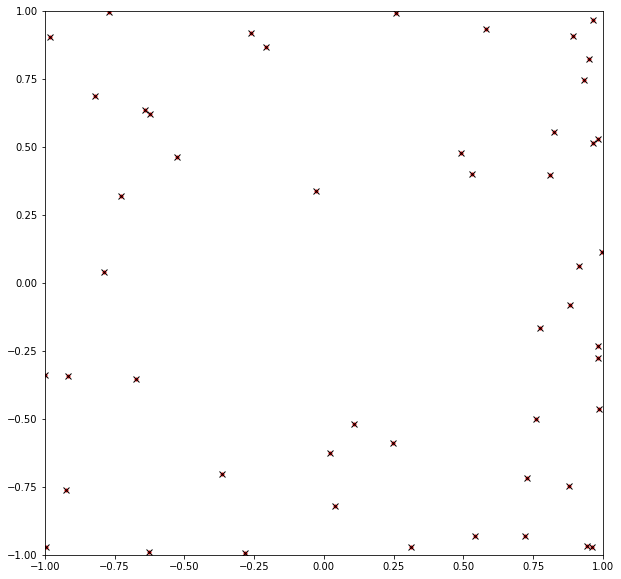

In [123]:
plt.figure(figsize=[10,10])
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(np.real(real_zeros[:,0]),np.real(real_zeros[:,1]),'r.')
plt.plot(np.real(zeros2[:,0]),np.real(zeros2[:,1]),'kx')
plt.show()

In [112]:
len(zeros2), len(real_zeros)

(50, 50)

In [113]:
len(np.unique(zeros2.round(4) , axis=0))

50

In [114]:
maximal_residual(polys, real_zeros)

5.179005091942864e-05

In [105]:
maximal_residual(polys, zeros2)

3.743505618839167e-05

In [116]:
len(np.unique(np.vstack([zeros2, real_zeros]).round(4) , axis=0))

50

In [117]:
for curr_zero in real_zeros:
    #curr_zero = newton_polish(polys, curr_zero)
    if np.any(np.abs(curr_zero) > 1):
        continue
    dist = np.min(np.linalg.norm(zeros2 - curr_zero, axis = 1))
    if dist > .0001:
        print(curr_zero, dist)

In [118]:
for curr_zero in zeros2:
    #curr_zero = newton_polish(polys, curr_zero)
    if np.any(np.abs(curr_zero) > 1):
        continue
    dist = np.min(np.linalg.norm(real_zeros - curr_zero, axis = 1))
    if dist > .0001:
        print(curr_zero, dist)

In [119]:
for curr_zero in real_zeros:
    #curr_zero = newton_polish(polys, curr_zero)
    if np.any(np.abs(curr_zero) > 1):
        continue
    norms = np.linalg.norm(real_zeros - curr_zero, axis = 1)
    norms = norms[norms > 1.e-10]
    dist = np.min(norms)
    if dist < .00001:
        print(curr_zero, dist)

In [124]:
np.linspace(0,2,5,retstep=True)

(array([0. , 0.5, 1. , 1.5, 2. ]), 0.5)

In [ ]:
zeros = np.array(zeros2)

final_zeros = []
while len(zeros) > 0:
    curr_zero = zeros[0]
    if np.any(np.abs(curr_zero) > 1):
        continue
    norms = np.linalg.norm(zeros - curr_zero, axis = 1)
    curr_zeros = zeros[norms < 1.e-5]
    zeros = zeros[norms >= 1.e-5]
    
    if len(curr_zeros) == 1:
        final_zeros.append(curr_zeros[0])
    else:
        avg_zero = np.mean(curr_zeros, axis = 0)
        final_zeros.append(avg_zero)
#np.vstack(final_zeros)

In [163]:
def get_interval(steps):
    a = np.array([-1.]*dim)
    b = np.array([1.]*dim)
    RAND = 0.5139303900908738
    for step in steps:
        diffs1 = ((b-a)*RAND)
        diffs2 = ((b-a)-(b-a)*RAND)
        if step == 0:
            a += diffs1
        elif step == 1:
            a[0] += diffs1[0]
            b[1] -= diffs2[1]
        elif step == 2:
            b -= diffs2
        elif step == 3:
            a[1] += diffs1[1]
            b[0] -= diffs2[0]
    return a,b

steps = [1,1,0,0,1]
a,b = get_interval(steps)
get_interval(steps)

(array([ 0.94573468, -0.59655713]), array([ 1.        , -0.53241552]))

In [ ]:

steps = [1,1,0,0,1]
a,b = get_interval(steps)
get_interval(steps)

In [ ]:
-0.86407797-0.j -0.01732634+0.j

In [ ]:
zeros3 = solve(polys, a, b, interval_data=True, plot_intervals=True, contours=True,\
               show_zeros=True, polish = False)

In [ ]:
zeros2

In [ ]:
a[0],b[0], (a[0]+b[0])/2

In [ ]:
0.67576971

In [ ]:
2*(0.67576971 - a[0]) / (b[0] - a[0]) - 1

In [ ]:
2*(0.42662007 - a[1]) / (b[1] - a[1]) - 1

In [ ]:
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
%time zeros2 = solve(polys, a, b, interval_data=True)

In [ ]:
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
%time zeros2 = solve(polys, a, b, interval_data=True)

In [ ]:
from scipy.linalg import solve_triangular
from numalgsolve.polyroots import get_var_list
from numalgsolve.Multiplication import _random_poly
from numalgsolve.MacaulayReduce import find_degree
from numalgsolve.Multiplication import MSMultMatrix, MacaulayReduction, makeBasisDict
from numalgsolve.utils import slice_top
import scipy
from scipy import linalg
import math

def all_shifts0(polys, matrix_degree):
    shifts = dict()
    min_degree = np.min([poly.degree for poly in polys])
    for i in range(min_degree,matrix_degree+1):
        shifts[i] = list()
    for poly in polys:
        degree = matrix_degree - poly.degree
        dim = poly.dim
        mons = mon_combos([0]*dim,degree)
        for mon in mons:
            shifts[np.sum(mon)+poly.degree].append(tuple([poly,mon]))
    return shifts

def all_shifts(polys, matrix_degree):
    shifts = dict()
    min_degree = np.min([poly.degree for poly in polys])
    for i in range(min_degree,matrix_degree+1):
        shifts[i] = list()
    for poly in polys:
        degree = matrix_degree - poly.degree
        dim = poly.dim
        mons = mon_combos([0]*dim,degree)
        for mon in mons:
            shifts[np.sum(mon)+poly.degree].append(tuple([poly,mon]))
    
    flat_shifts = list()
    for i in shifts.keys():
        flat_shifts += list(shifts[i])
    
    return flat_shifts

def null(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps*s[0]), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

def new_terms(coeffs, old_term_set):
    new_term_set = set()
    for coeff in coeffs:
        for term in zip(*np.where(coeff!=0)):
            if term not in old_term_set:
                new_term_set.add(tuple(term))
    if len(new_term_set)==0:
        return None
    else:
        return np.vstack(new_term_set)

def matrix_mult1(A,B):
    return A@B

def matrix_mult2(A,B):
    return A@B
    
def null_reduce(N,shifts,old_matrix_terms,bigShape):
    old_term_set = set()
    for term in old_matrix_terms:
        old_term_set.add(tuple(term))
    coeffs = list()
    for poly,shift in shifts:
        coeffs.append(poly.mon_mult(shift,returnType = 'Matrix'))

    new_matrix_terms = new_terms(coeffs, old_term_set)
    
    if new_matrix_terms is None:
        matrix_terms = old_matrix_terms

        old_matrix_term_indexes = list()
        for row in old_matrix_terms.T:
            old_matrix_term_indexes.append(row)

        #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
        added_zeros = np.zeros(bigShape)
        old_flat_polys = list()
        for coeff in coeffs:
            slices = slice_top(coeff)
            added_zeros[slices] = coeff
            old_flat_polys.append(added_zeros[old_matrix_term_indexes])
            added_zeros[slices] = np.zeros_like(coeff)

        R1 = np.reshape(old_flat_polys, (len(old_flat_polys),len(old_matrix_terms)))

        X = matrix_mult1(R1,N)
        if np.max(np.abs(X)) < 1.e-10: #N is still a valid null space
            return N, matrix_terms
        else:
            K = null(X)
            N = matrix_mult2(N,K)
            return N, matrix_terms
    else:
        matrix_terms = np.vstack([old_matrix_terms, new_matrix_terms])

        new_matrix_term_indexes = list()
        old_matrix_term_indexes = list()
        for row in new_matrix_terms.T:
            new_matrix_term_indexes.append(row)
        for row in old_matrix_terms.T:
            old_matrix_term_indexes.append(row)

        #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
        added_zeros = np.zeros(bigShape)
        new_flat_polys = list()
        old_flat_polys = list()
        for coeff in coeffs:
            slices = slice_top(coeff)
            added_zeros[slices] = coeff
            new_flat_polys.append(added_zeros[new_matrix_term_indexes])
            old_flat_polys.append(added_zeros[old_matrix_term_indexes])
            added_zeros[slices] = np.zeros_like(coeff)

        R1 = np.reshape(old_flat_polys, (len(old_flat_polys),len(old_matrix_terms)))
        R2 = np.reshape(new_flat_polys, (len(new_flat_polys),len(new_matrix_terms)))
        
        X = np.hstack([matrix_mult1(R1,N),R2])
        K = null(X)
        
        cut = N.shape[1]
        K1 = K[:cut]
        K2 = K[cut:]
        N = np.vstack([matrix_mult2(N,K1),K2])
        
        return N, matrix_terms

def fast_null(polys, max_shifts = 700):
    matrix_degree = find_degree(polys)
    dim = polys[0].dim
    bigShape = [matrix_degree+1]*dim
    
    shifts = all_shifts0(polys, matrix_degree)
    degs = list(shifts.keys())
        
    initial_shifts = shifts[degs[0]]
    initial_coeffs = list()
    for poly,shift in initial_shifts:
        initial_coeffs.append(poly.mon_mult(shift,returnType = 'Matrix'))

    matrix, matrix_terms, cuts = MSMultMatrix(initial_coeffs, degs[0], dim)
    N = null(matrix)
    #print(degs[-1])
    degs = degs[1:]
    spot = 0
    while spot < len(degs):
        deg = degs[spot]
        new_shifts = shifts[deg]
        #print(deg,len(new_shifts))
        if len(new_shifts) < max_shifts:
            if spot < len(degs)-1:
                while len(new_shifts)+len(shifts[degs[spot+1]]) < max_shifts:
                    spot += 1
                    new_shifts += shifts[degs[spot]]
                    if spot == len(degs)-1:
                        break
            N,matrix_terms = null_reduce(N,new_shifts,matrix_terms,bigShape)
        else:
            for i in range(math.ceil(len(new_shifts)/max_shifts)):
                current_shifts = new_shifts[i*max_shifts:(i+1)*max_shifts]
                N,matrix_terms = null_reduce(N,current_shifts,matrix_terms,bigShape)
        spot += 1
    
    return N, matrix_terms, matrix_degree

def fast_TVB_solve(polys,max_shifts=700):
    N, matrix_terms, matrix_degree = fast_null(polys,max_shifts=max_shifts)
    dim = matrix_terms.shape[1]
    degs = np.sum(matrix_terms,axis=1)
    max_deg = np.max(degs)
    order = np.argsort(degs)
    N = N[order]
    matrix_terms = matrix_terms[order]
            
    degs = np.sum(matrix_terms,axis=1)
    cut1 = dim+1
    cut2 = len(matrix_terms) - len(np.where(degs == degs[-1])[0])
    #cut1 = len(np.where(degs == degs[0])[0])
    #cut2 = len(matrix_terms) - dim - 1
    cuts = tuple((cut1,cut2))
        
    NT, matrix_terms = rrqr_reduceTelenVanBarel2(N.T,matrix_terms,cuts)
    
    height = NT.shape[0]
    X = -solve_triangular(NT[:,:height],NT[:,height:]).T
    n,m = X.shape
    matrix = np.hstack((np.eye(n),X))
        
    #print(matrix)
    matrix_terms = np.vstack((matrix_terms[m:],matrix_terms[:m]))
    
    VB = matrix_terms[n:]
    basisDict = makeBasisDict(matrix, matrix_terms, VB, True)
        
    return basisDict, VB, matrix_degree

def TVBMultMatrix(polys,max_shifts=700, poly_type="MultiPower"):
    basisDict, VB, degree = fast_TVB_solve(polys,max_shifts=max_shifts)
        
    dim = max(f.dim for f in polys)

    # Get random polynomial f
    f = _random_poly(poly_type, dim)[0]
    
    #Dictionary of terms in the vector basis their spots in the matrix.
    VBdict = {}
    spot = 0
    for row in VB:
        VBdict[tuple(row)] = spot
        spot+=1
    
    # Build multiplication matrix m_f
    mMatrix = np.zeros((len(VB), len(VB)))
    for i in range(VB.shape[0]):
        #print("current - {}".format(VB[i]))
        f_coeff = f.mon_mult(VB[i], returnType = 'Matrix')
        for term in zip(*np.where(f_coeff != 0)):
            #print(term)
            if term in VBdict:
                mMatrix[VBdict[term]][i] += f_coeff[term]
            else:
                mMatrix[:,i] -= f_coeff[term]*basisDict[term]

    return mMatrix, VBdict

def fast_TVB(polys,max_shifts=700):
    m_f, var_dict = TVBMultMatrix(polys,max_shifts=max_shifts)
    
    dim = max(f.dim for f in polys)
    
    # Get left eigenvectors

    e = np.linalg.eig(m_f.T)
    eig = e[1]
    num_vectors = eig.shape[1]

    eig_vectors = [eig[:,i] for i in range(num_vectors)] # columns of eig
    roots = []
    for v in eig_vectors:
        #print(v)
        if v[var_dict[tuple(0 for i in range(dim))]] == 0:
            continue
        root = np.zeros(dim, dtype=complex)
        spot = np.zeros(dim)
        # This will always work because var_indexes and root have the
        # same length - dim - and var_indexes has the variables in the
        # order they should be in the root
        for i in range(dim):
            spot[i] = 1
            root[i] = v[var_dict[tuple(spot)]]/v[var_dict[tuple(0 for i in range(dim))]]
            spot[i] = 0
        roots.append(root)
        #roots.append(newton_polish(polys,root))
    return roots

In [ ]:
deg = 3
dim = 4
power = True
polys = polyList(deg,dim,power,Type="standard")

In [ ]:
from numalgsolve.polynomial import is_power
is_power(polys)

In [ ]:
%time zeros = fast_TVB(polys,max_shifts=1500)

In [ ]:
tol = 1.e-5

print('Fast TVB - {} out of {}'.format(np.sum([in_zeros(zeros, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)
"""
print('Mult - {} out of {}'.format(np.sum([in_zeros(zeros1, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros1, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)

print('Div - {} out of {}'.format(np.sum([in_zeros(zeros2, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros2, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)
"""
print()

In [ ]:
zeros = fast_TVB(polys)
zeros

In [ ]:
polys[0](zeros)

In [ ]:
deg = 3
dim = 3
power = True
polys = polyList(deg,dim,power,Type="standard")

In [ ]:
%prun N,matrix_terms, matrix_degree = fast_null(polys, max_shifts=650)

In [ ]:
4090068 function calls (4087744 primitive calls) in 100.235 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10   43.003    4.300   43.074    4.307 decomp_svd.py:16(svd)
        9   28.146    3.127   28.146    3.127 <ipython-input-527-483e3204ae65>:41(matrix_mult2)
        9   11.060    1.229   11.060    1.229 <ipython-input-527-483e3204ae65>:38(matrix_mult1)
        9    6.256    0.695    8.202    0.911 <ipython-input-527-483e3204ae65>:27(new_terms)
       10    2.893    0.289    2.893    0.289 {method 'compress' of 'numpy.ndarray' objects}
        9    2.212    0.246   99.171   11.019 <ipython-input-527-483e3204ae65>:44(null_reduce)
       46    2.094    0.046    2.094    0.046 {built-in method numpy.core.multiarray.concatenate}
  3659071    1.164    0.000    1.164    0.000 {method 'add' of 'set' objects}

In [ ]:
from numalgsolve.TelenVanBarel import add_polys

def test_matrix(polys, matrix_terms):
    matrix_degree = find_degree(polys)
    dim = polys[0].dim
    coeff_list = []
    for poly in polys:
        coeff_list = add_polys(matrix_degree, poly, coeff_list)  
    
    bigShape = [matrix_degree+1]*dim

    matrix_term_indexes = list()
    for row in matrix_terms.T:
        matrix_term_indexes.append(row)

    #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
    added_zeros = np.zeros(bigShape)
    flat_polys = list()
    for coeff in coeff_list:
        slices = slice_top(coeff)
        added_zeros[slices] = coeff
        flat_polys.append(added_zeros[matrix_term_indexes])
        added_zeros[slices] = np.zeros_like(coeff)
        coeff = 0
    poly_coeffs = 0

    #Make the matrix. Reshape is faster than stacking.
    matrix = np.reshape(flat_polys, (len(flat_polys),len(matrix_terms)))
    return matrix

In [ ]:
deg = 10
dim = 3
power = True
polys = polyList(deg,dim,power,Type="standard")
N,matrix_terms,deg = fast_null(polys)

In [ ]:
matrix = test_matrix(polys,matrix_terms)

In [ ]:
np.max(np.abs(matrix@N))

In [ ]:
#Future test case!
a = MultiPower('x0^2+-1')
b = MultiPower('x0^4+-1')
c = MultiPower('x0^2+-2x0+1')
roots([a,b,c])

In [ ]:
from numalgsolve import subdivision as sbd
deg = 10
dim = 2
power = False
polys = polyList(deg,dim,power)
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
#sbd.solve(polys,a,b)
#zeros = pr.solve(polys, method='div')
#print(len(zeros))

In [ ]:
run_trial(polys, division,tol=1.e-3)

In [ ]:
zeros_bertini = run_bertini(polys)
zeros_bertini_real = zeros_bertini[np.sum(np.abs(zeros_bertini.imag) < 1.e-10,axis = 1) == dim]
zeros_bertini_final = zeros_bertini_real[np.sum(np.abs(zeros_bertini_real) < 1,axis = 1) == dim]
zeros_bertini_final

In [ ]:
%prun sbd.solve(polys,a,b)

In [ ]:
((30/35)*.8 + (9/10)*.2)*300